In [2]:
from PyHa.statistics import *
from PyHa.IsoAutio import *
from PyHa.visualizations import *
from PyHa.annotation_post_processing import *
import pandas as pd

c:\Users\shiva\miniconda3\envs\species-id\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\shiva\miniconda3\envs\species-id\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\shiva\miniconda3\envs\species-id\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\shiva\miniconda3\envs\species-id\lib\site-pack

In [ ]:
# !pip3 install torch torchvision torchaudio

### Dictionary that defines the isolation technique and parameters used to generate automated labels 

## Running Moment to Moment Labeling System on a Directory of WAV Files 

In [3]:
path = "./TEST/"

In [4]:
# Example parameters for BirdNET
# isolation_parameters = {
#    "model" : "birdnet",
#    "output_path" : "outputs",
#    "lat" : 35.4244,
#    "lon" : -120.7463,
#    "week" : 18,
#    "min_conf" : 0.1,
#    "filetype" : "wav", 
#    "num_predictions" : 1,
#    "write_to_csv" : False
# }

# Example Parameters for Microfaune
# isolation_parameters = {
#      "model" :          "microfaune",
#      "technique" :       "steinberg",
#      "threshold_type" :  "median",
#      "threshold_const" : 2.0,
#      "threshold_min" :   0.0,
#      "window_size" :     2.0,
#      "chunk_size" :      5.0,
#      "verbose"     :     True
# }

# Example parameters for TweetyNET
isolation_parameters = {
    "model" : "tweetynet",
    "tweety_output": True,
   "technique" : "steinberg",
    "threshold_type" : "median",
    "threshold_const" : 2.0,
    "threshold_min" : 0.0,
    "window_size" : 2.0,
    "chunk_size" : 5.0
}

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Pandas Ouput of Automated Labeling 

In [12]:
%%capture
import os
import librosa.display
import numpy as np
import scipy.signal as scipy_signal
import matplotlib.pyplot as plt
test_path = "./TEST/"
path_folders = os.listdir(test_path)
print(path_folders)
for folder in path_folders:
    automated_df = generate_automated_labels(test_path+folder+'/',isolation_parameters);
    df = annotation_chunker_no_duplicates(automated_df, 5)
    for index, row in df.iterrows():
        file_name = row["IN FILE"]
        folder_name = row["FOLDER"]
        
        path = folder_name+file_name
        offset = float(row["OFFSET"])
        duratiom = float(row["DURATION"])
        normalized_sample_rate=44100
        try:
            SIGNAL, SAMPLE_RATE = librosa.load(path, offset=offset, duration=duratiom, sr=None, mono=True)
            SIGNAL = SIGNAL * 32768
        except BaseException:
            print("Failed to load" + path)
                
        # Resample the audio if it isn't the normalized sample rate
        try:
            if SAMPLE_RATE != normalized_sample_rate:
                rate_ratio = normalized_sample_rate / SAMPLE_RATE
                SIGNAL = scipy_signal.resample(
                SIGNAL, int(len(SIGNAL) * rate_ratio))
                SAMPLE_RATE = normalized_sample_rate
        except Exception as e:
            print("Failed to Downsample" + path + str(e))
                
        # convert stereo to mono if needed
        # Might want to compare to just taking the first set of data.
        if len(SIGNAL.shape) == 2:
            SIGNAL = SIGNAL.sum(axis=1) / 2

        D = np.abs(librosa.stft(SIGNAL))**2
        S = librosa.feature.melspectrogram(S=D, sr=normalized_sample_rate,fmax=normalized_sample_rate/2,fmin=1400)
        # save s directly -> as an image preferably
        fig, ax = plt.subplots()
        S_dB = librosa.power_to_db(S, ref=np.max)
        img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=normalized_sample_rate,fmax=normalized_sample_rate/2, fmin=1400,ax=ax)
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        ax.set(title='Mel-frequency spectrogram')
        folder_name = folder_name[:-1]
        bird_name = folder_name[6:]
        bird_path = "./IMAGES_HighPassFilter"+bird_name+"/"
        isExist = os.path.exists(bird_path)
        if not isExist:
            # Create a new directory because it does not exist
            os.makedirs(bird_path)
        plt.savefig(bird_path+"/"+str(index)+".png")
#print(automated_df)

In [14]:
path_folders = os.listdir("./IMAGES/")


['abethr1', 'abhori1', 'abythr1', 'afecuc1', 'affeag1', 'afgfly1', 'afghor1', 'afmdov1', 'afpkin1', 'afpwag1', 'afrgos1']


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255   ,
    # shear_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode="nearest",) # set validation split

train_generator = train_datagen.flow_from_directory(
    "./IMAGES",
    target_size=(432, 288),
    batch_size=100,
    class_mode='categorical',
    subset='training',
    shuffle=True,) # set as training data

validation_generator = train_datagen.flow_from_directory(
    "./IMAGES", # same directory as training data
    target_size=(432, 288),
    batch_size=100  ,
    class_mode='categorical',
    subset='validation',
    shuffle=True, ) # set as validation data

Found 2837 images belonging to 11 classes.
Found 704 images belonging to 11 classes.


In [22]:

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(432,288,3)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
# dense value should be number of classes
model.add(Dense(11, activation='softmax'))

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    "balanced", np.unique(train_generator.classes), train_generator.classes
)

In [25]:
# Train the model
model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    class_weight=class_weights,
)

Epoch 1/10


: 

: 

### Function that gathers statistics about the duration of annotations

In [ ]:
annotation_duration_statistics(automated_df)

,COUNT,MODE,MEAN,STANDARD DEVIATION,MIN,Q1,MEDIAN,Q3,MAX
0,8,0.05,0.241279,0.216896,0.046512,0.087209,0.139535,0.319767,0.627907


### Function that converts annotations into 3 second chunks

In [26]:
#annotation_chunker(automated_df, 3)
df = annotation_chunker_no_duplicates(automated_df, 5)

In [36]:
help("modules")


Please wait a moment while I gather a list of all available modules...



c:\Users\shiva\miniconda3\envs\species-id\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)
c:\Users\shiva\miniconda3\envs\species-id\lib\pkgutil.py:92: MatplotlibDeprecationWarning: 
The matplotlib.compat module was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  __import__(info.name)


NOTE: Redirects are currently not supported in Windows or MacOs.
c:\Users\shiva\miniconda3\envs\species-id\lib\pkgutil.py:107: VisibleDeprecationWarning: zmq.eventloop.minitornado is deprecated in pyzmq 14.0 and will be removed.
    Install tornado itself to use zmq with the tornado IOLoop.
    
  yield from walk_packages(path, info.name+'.', onerror)


IPython             certifi             msilib              sunau
OpenSSL             cffi                msvcrt              symbol
PIL                 cgi                 multiprocessing     sympyprinting
PyQt5               cgitb               nbclient            symtable
__future__          chardet             nbconvert           sys
_abc                chunk               nbformat            sysconfig
_ast                cmath               nest_asyncio        tabnanny
_asyncio            cmd                 netbios             tarfile
_bisect             code                netrc               telnetlib
_blake2             codecs              nntplib             tempfile
_bootlocale         codeop              notebook            tensorboard
_bz2                collections         nt                  tensorflow
_cffi_backend       colorama            ntpath              tensorflow_estimator
_codecs             colorsys            ntsecuritycon       termcolor
_codecs_cn          

c:\Users\shiva\miniconda3\envs\species-id\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
c:\Users\shiva\miniconda3\envs\species-id\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


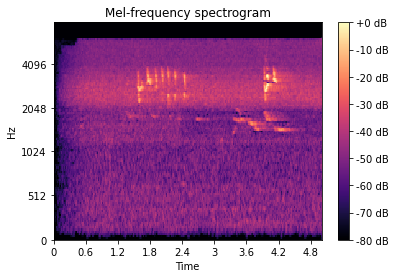

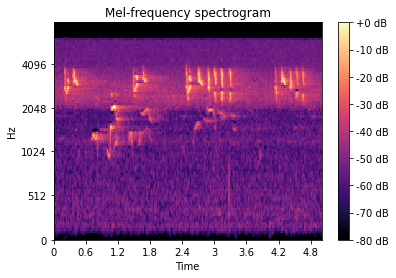

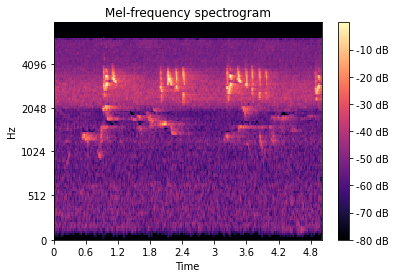

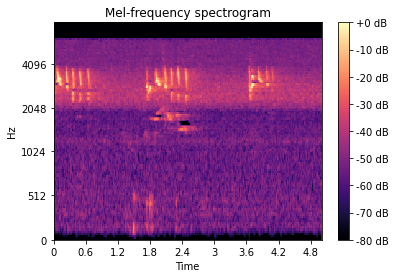

In [37]:
import librosa.display


import numpy as np
import scipy.signal as scipy_signal
import matplotlib.pyplot as plt
for index, row in df.iterrows():
    file_name = row["IN FILE"]
    folder_name = row["FOLDER"]
    
    path = folder_name+file_name
    offset = float(row["OFFSET"])
    duratiom = float(row["DURATION"])
    normalized_sample_rate=44100
    try:
        SIGNAL, SAMPLE_RATE = librosa.load(path, offset=offset, duration=duratiom, sr=None, mono=True)
        SIGNAL = SIGNAL * 32768
    except BaseException:
        print("Failed to load" + path)
            
    # Resample the audio if it isn't the normalized sample rate
    try:
        if SAMPLE_RATE != normalized_sample_rate:
            rate_ratio = normalized_sample_rate / SAMPLE_RATE
            SIGNAL = scipy_signal.resample(
            SIGNAL, int(len(SIGNAL) * rate_ratio))
            SAMPLE_RATE = normalized_sample_rate
    except Exception as e:
        print("Failed to Downsample" + path + str(e))
            
    # convert stereo to mono if needed
    # Might want to compare to just taking the first set of data.
    if len(SIGNAL.shape) == 2:
        SIGNAL = SIGNAL.sum(axis=1) / 2

    D = np.abs(librosa.stft(SIGNAL))**2
    S = librosa.feature.melspectrogram(S=D, sr=normalized_sample_rate)

    fig, ax = plt.subplots()
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=normalized_sample_rate,fmax=8000, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram')


### Human Manual Labels for Comparison 

In [ ]:
manual_df = pd.read_csv("ScreamingPiha_Manual_Labels.csv")
#manual_df = pd.read_csv("BirdCLEF2020_Validation.csv")
manual_df

In [17]:
annotation_duration_statistics(manual_df)

NameError: name 'manual_df' is not defined

### Histogram Visualization of Annotation Lengths

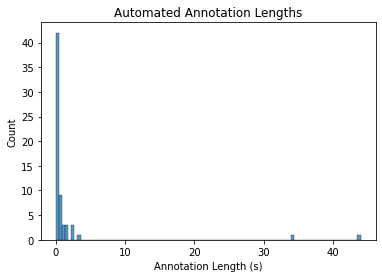

In [18]:
annotation_duration_histogram(automated_df, n_bins = 100, title = "Automated Annotation Lengths")

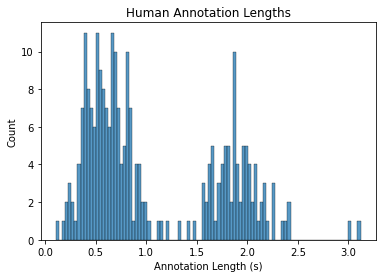

In [17]:
annotation_duration_histogram(manual_df, n_bins = 100, title = "Human Annotation Lengths")
# In the Screaming Piha clips we can see two distinct clusters based on the "Whoa" vocalizations (.25-1.25s)
# and the "Pee-Haw" vocalizations (1.25-2.5s)

### Helper function to convert to kaleidoscope-compatible format 

In [ ]:
kaleidoscope_conversion(manual_df)

## Different Combinations of Spectrogram and Local Score Visualization Graphs
Note: Not all models support local score arrays.

### Baseline Graph without any annotations

No handles with labels found to put in legend.


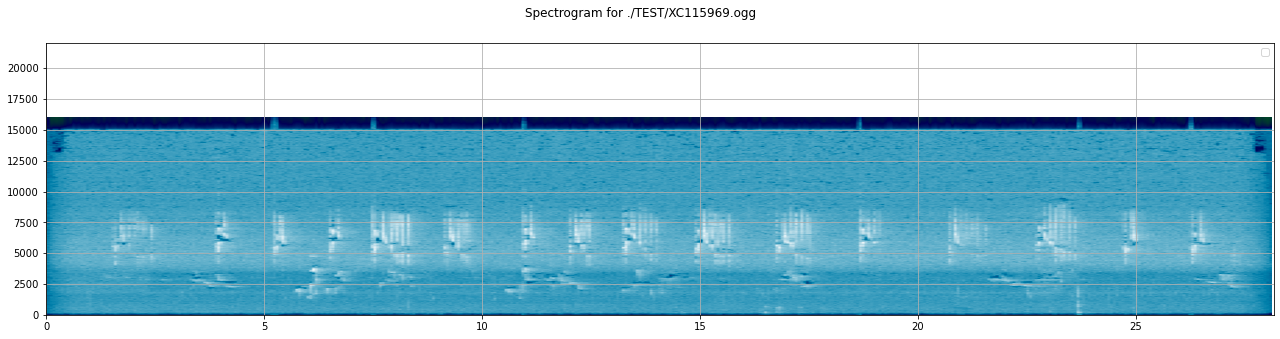

In [19]:
clip_path = "./TEST/XC115969.ogg"
spectrogram_visualization(clip_path)

### Baseline graph with log scale

No handles with labels found to put in legend.


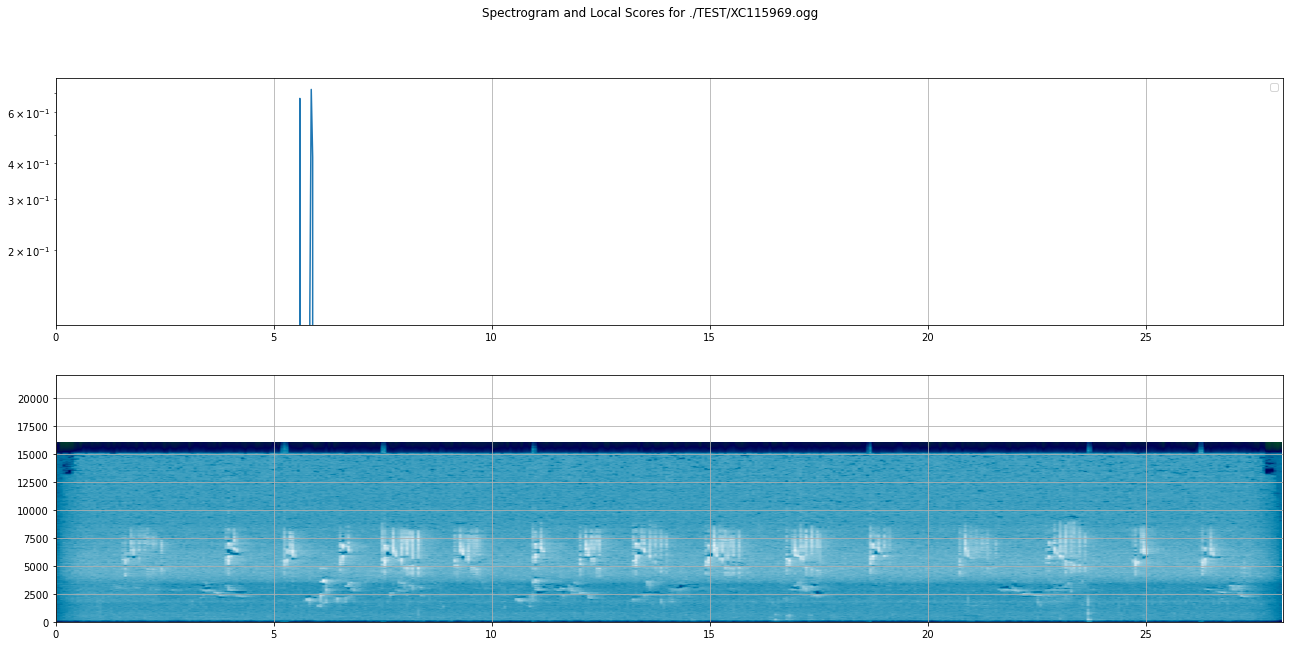

In [20]:
spectrogram_visualization(clip_path, isolation_parameters = isolation_parameters, log_scale = True)

### Baseline graph with normalized local score values between [0,1] 

No handles with labels found to put in legend.


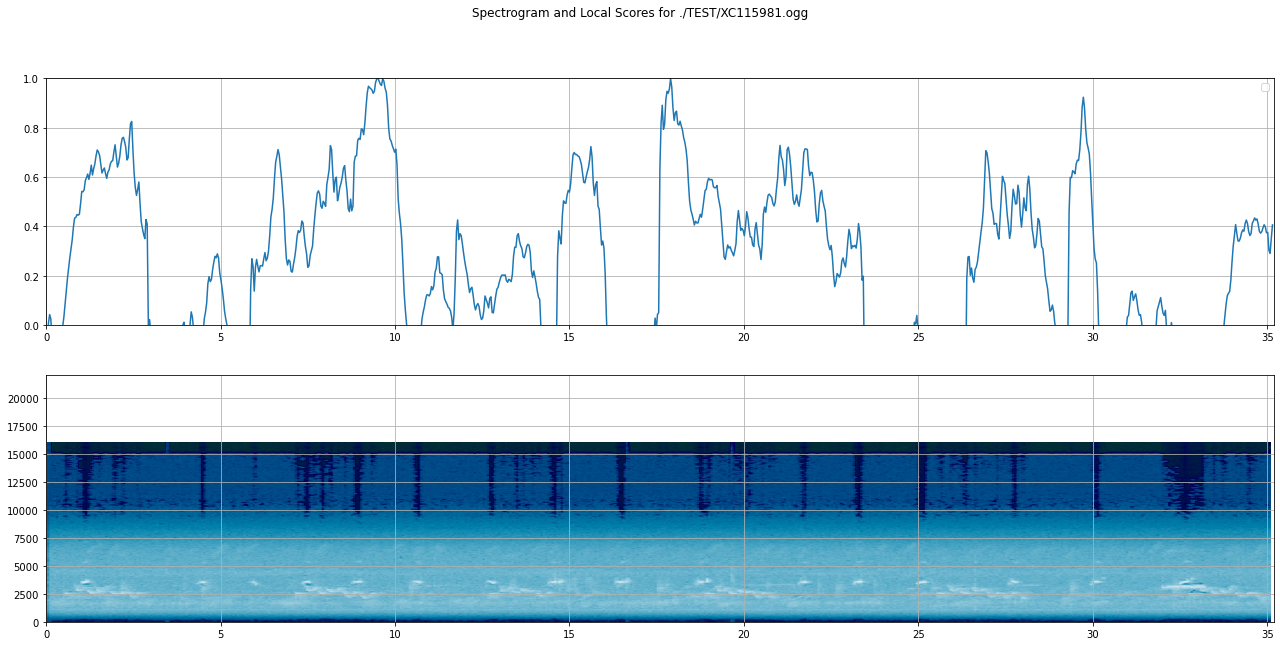

In [10]:
spectrogram_visualization(clip_path, isolation_parameters = isolation_parameters, normalize_local_scores = True)

### Graph with Automated Labeling 

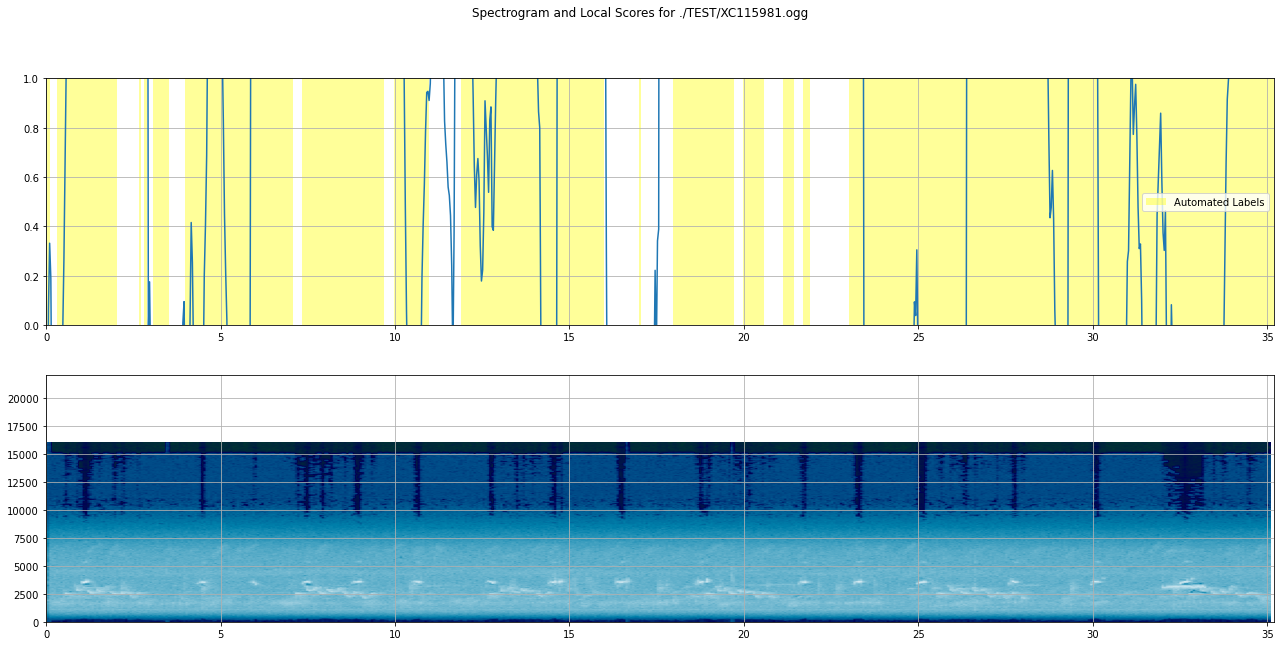

In [11]:
spectrogram_visualization(clip_path,build_automated_df = True, isolation_parameters = isolation_parameters)

### Graph with Human Labelling

In [ ]:
spectrogram_visualization(clip_path, premade_annotations_df = manual_df[manual_df["IN FILE"] == "ScreamingPiha2.wav"],premade_annotations_label = "Piha Human Labels")

### Graph with Both Automated and Human Labels 
    Orange ==> True Positive
    Red ==> False Negative
    Yellow ==> False Positive
    White ==> True Negative

In [ ]:
spectrogram_visualization(clip_path,build_automated_df = True,isolation_parameters=isolation_parameters,premade_annotations_df = manual_df[manual_df["IN FILE"] == "ScreamingPiha2.wav"])

### Another Visualization of True Positives, False Positives, False Negatives, and True Negatives 

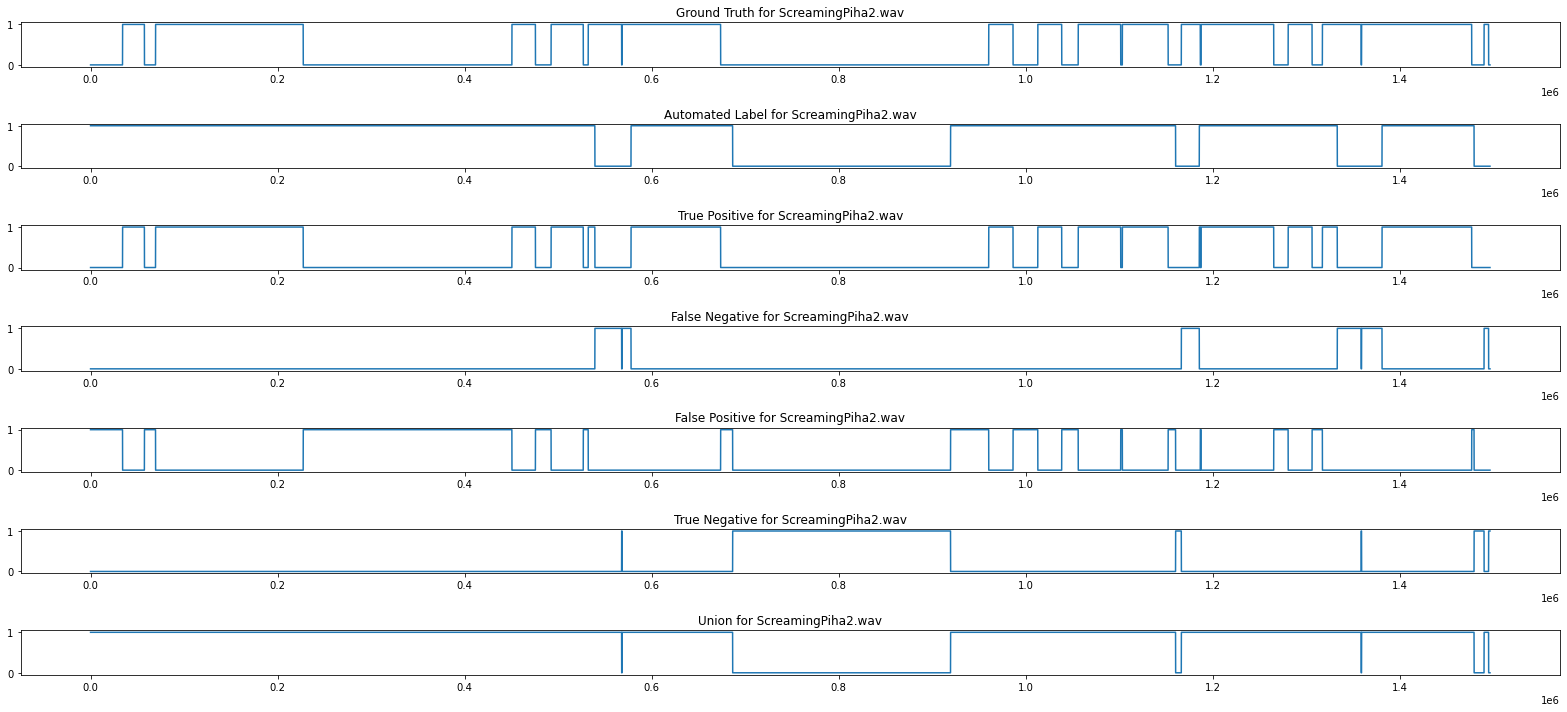

In [18]:
automated_piha_df = automated_df[automated_df["IN FILE"] == "ScreamingPiha2.wav"]
manual_piha_df = manual_df[manual_df["IN FILE"] == "ScreamingPiha2.wav"]
piha_stats = binary_visualization(automated_piha_df,manual_piha_df)

### Function that generates statistics to gauge efficacy of automated labeling compared to human labels 

In [19]:
statistics_df = automated_labeling_statistics(automated_df,manual_df,stats_type = "general");
statistics_df

,FOLDER,IN FILE,MANUAL ID,TRUE POSITIVE,FALSE POSITIVE,FALSE NEGATIVE,TRUE NEGATIVE,UNION,PRECISION,RECALL,F1,Global IoU
0,./TEST/,ScreamingPiha7.wav,bird,49.756531,78.644490,1.873673,3.315510,130.274694,0.387509,0.963710,0.552754,0.381936
1,./TEST/,ScreamingPiha2.wav,bird,16.004286,9.720952,2.487438,5.720385,28.212676,0.622124,0.865484,0.723898,0.567273
2,./TEST/,ScreamingPiha6.wav,bird,24.858254,35.185193,0.000000,10.591633,60.043447,0.414004,1.000000,0.585577,0.414004
3,./TEST/,ScreamingPiha1.wav,bird,28.263900,3.394807,0.957279,0.000000,32.615986,0.892769,0.967240,0.928514,0.866566
4,./TEST/,ScreamingPiha10.wav,bird,32.995147,40.981179,6.386145,9.420385,80.362472,0.446023,0.837838,0.582143,0.410579
5,./TEST/,ScreamingPiha4.wav,bird,5.401565,4.067959,0.000000,4.088027,9.469524,0.570416,1.000000,0.726452,0.570416
6,./TEST/,ScreamingPiha11.wav,bird,30.032902,24.502948,7.784467,1.575193,62.320317,0.550700,0.794156,0.650392,0.481912
7,./TEST/,ScreamingPiha8.wav,bird,6.900091,36.813243,0.000000,0.407483,43.713333,0.157849,1.000000,0.272659,0.157849
8,./TEST/,ScreamingPiha5.wav,bird,30.348617,17.702200,4.950023,1.177120,53.000839,0.631594,0.859767,0.728226,0.572606
9,./TEST/,ScreamingPiha9.wav,bird,23.139819,6.785760,5.452608,1.924671,35.378186,0.773245,0.809299,0.790862,0.654070


### Function that takes the statistical ouput of all of the clips and gets the equivalent global scores 

In [20]:
global_dataset_statistics(statistics_df)

,MANUAL ID,PRECISION,RECALL,F1,Global IoU
0,bird,0.492163,0.89402,0.634842,0.465032


### Function that takes in the manual and automated labels for a clip and outputs human label-by-label IoU Scores. Used to derive statistics that measure how well a system is isolating desired segments of audio clips

In [21]:
Intersection_over_Union_Matrix = clip_IoU(automated_piha_df,manual_piha_df)
print(Intersection_over_Union_Matrix)

[[0.0532 0.     0.     0.     0.    ]
 [0.1718 0.     0.     0.     0.    ]
 [0.0433 0.     0.     0.     0.    ]
 [0.0466 0.     0.     0.     0.    ]
 [0.0695 0.     0.     0.     0.    ]
 [0.0638 0.     0.     0.     0.    ]
 [0.0125 0.     0.     0.     0.    ]
 [0.     0.1425 0.     0.     0.    ]
 [0.     0.     0.1081 0.     0.    ]
 [0.     0.7306 0.     0.     0.    ]
 [0.     0.     0.1888 0.     0.    ]
 [0.     0.     0.1063 0.     0.    ]
 [0.     0.     0.2034 0.     0.    ]
 [0.     0.     0.     0.0064 0.    ]
 [0.     0.     0.     0.1734 0.    ]
 [0.     0.     0.     0.5261 0.    ]
 [0.     0.     0.     0.     0.0821]
 [0.     0.     0.     0.0919 0.    ]
 [0.     0.     0.     0.     0.8738]
 [0.     0.     0.     0.     0.    ]]


### Function that turns the IoU Matrix of a clip into true positive and false positives values, as well as computing the precision, recall, and F1 statistics

In [22]:
matrix_IoU_Scores(Intersection_over_Union_Matrix,manual_piha_df,0.5)

,FOLDER,IN FILE,MANUAL ID,TRUE POSITIVE,FALSE NEGATIVE,FALSE POSITIVE,PRECISION,RECALL,F1
0,./TEST/,ScreamingPiha2.wav,bird,3,17,2,0.6,0.15,0.24


### Wrapper function that takes matrix_IoU_Scores across multiple clips. Allows user to modify the threshold that determines whether or not a label is a true positive.

In [23]:
stats_df = automated_labeling_statistics(automated_df,manual_df,stats_type = "IoU",threshold = 0.5)
stats_df

,FOLDER,IN FILE,MANUAL ID,TRUE POSITIVE,FALSE NEGATIVE,FALSE POSITIVE,PRECISION,RECALL,F1
0,./TEST/,ScreamingPiha7.wav,bird,0,51,7,0.0000,0.000,0.0000
1,./TEST/,ScreamingPiha2.wav,bird,3,17,2,0.6000,0.150,0.2400
2,./TEST/,ScreamingPiha6.wav,bird,0,19,7,0.0000,0.000,0.0000
3,./TEST/,ScreamingPiha1.wav,bird,0,88,4,0.0000,0.000,0.0000
4,./TEST/,ScreamingPiha10.wav,bird,2,38,11,0.1538,0.050,0.0755
5,./TEST/,ScreamingPiha4.wav,bird,0,8,1,0.0000,0.000,0.0000
6,./TEST/,ScreamingPiha11.wav,bird,0,35,8,0.0000,0.000,0.0000
7,./TEST/,ScreamingPiha8.wav,bird,0,9,3,0.0000,0.000,0.0000
8,./TEST/,ScreamingPiha5.wav,bird,0,30,5,0.0000,0.000,0.0000
9,./TEST/,ScreamingPiha9.wav,bird,2,21,3,0.4000,0.087,0.1429


### Function that takes the output of dataset_IoU Statistics and ouputs a global count of true positives and false positives, as well as computing common metrics across the dataset

In [24]:
global_stats_df = global_statistics(stats_df)
global_stats_df

,MANUAL ID,TRUE POSITIVE,FALSE NEGATIVE,FALSE POSITIVE,PRECISION,RECALL,F1
0,N/A,7,322,52,0.1186,0.0213,0.0361
